# Importing necessary libraries 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import time
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import learning_curve

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Loading Training Data from CSV

In [2]:
data = pd.read_csv("/kaggle/input/aicomm/train.csv")

# Visualization of Target Variable Distribution: Retention Analysis

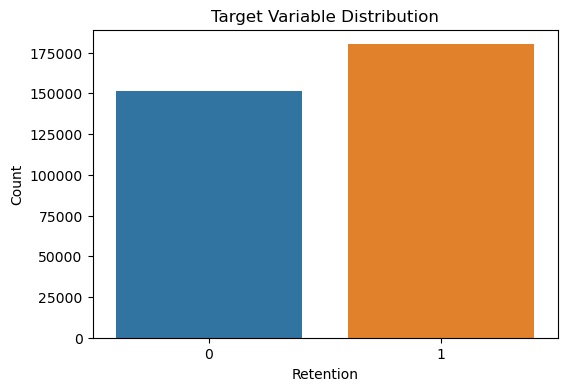

In [3]:
# Visualize target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_retained', data=data)
plt.title("Target Variable Distribution")
plt.xlabel("Retention")
plt.ylabel("Count")
plt.show()

# Data Preprocessing and Correlation Analysis for Feature Relationships

/tmp/ipykernel_32/2002667283.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


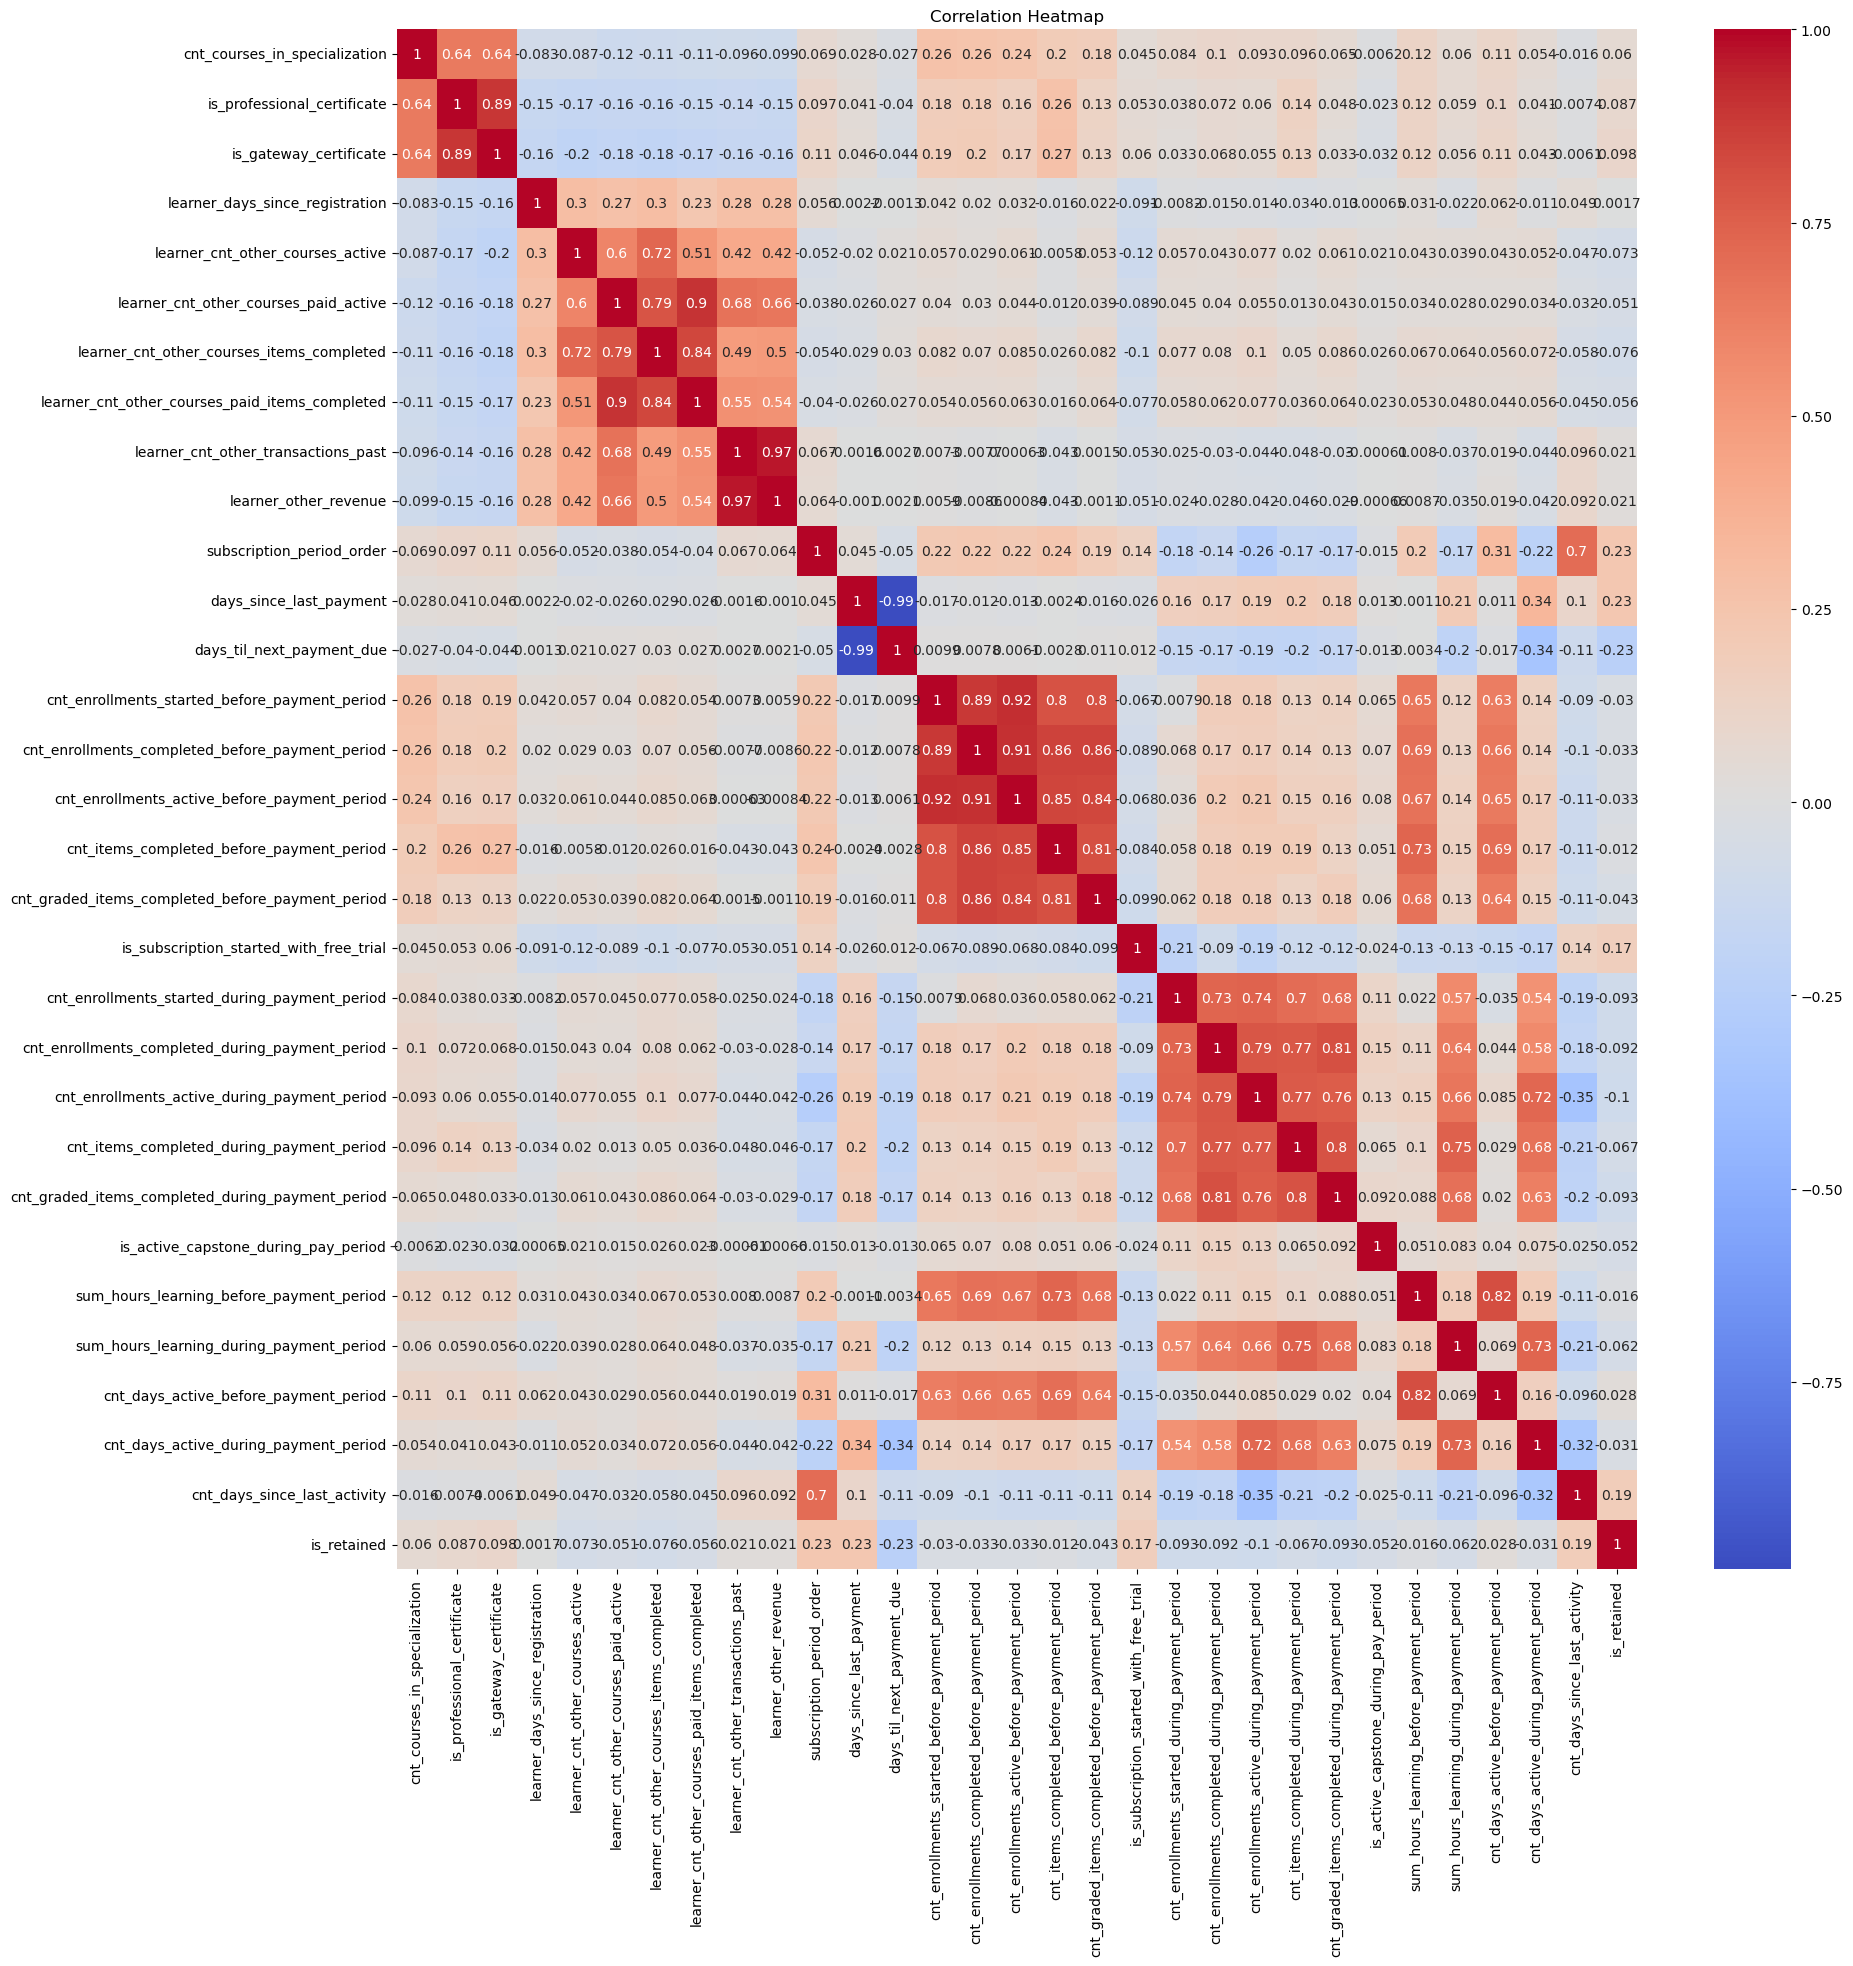

In [4]:
# Load your dataset
data = pd.read_csv("/kaggle/input/aicomm/train.csv")

# Remove Unnecessary Columns
columns_to_drop = ["ID", "subscription_id"]
data = data.drop(columns=columns_to_drop)

data = data.dropna()
# Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Exploration of Categorical Variables: Distribution and Counts

In [5]:
# Categorical Variables
categorical_columns = ["specialization_domain", "learner_country_group", "learner_gender", "subscription_period_order"]
for col in categorical_columns:
    print(data[col].value_counts())

Data Science                        113153
Business                             78600
Computer Science                     59872
Information Technology               51915
Arts and Humanities                   8398
Health                                5855
Language Learning                     5637
Physical Science and Engineering      2669
Social Sciences                       2489
Personal Development                  1868
Math and Logic                         706
Name: specialization_domain, dtype: int64
United States                        156571
Northern Europe                       32960
India                                 19094
Non-Brazil Latin America              18416
East Asia                             15592
Canada                                14660
Southern Europe                       14077
Southeast Asia                        10961
Africa and developing Middle East     10017
Eastern Europe                         9806
Middle East                            8538
R

# Analyzing Time Series: Monthly Retention Rate Trends

/tmp/ipykernel_32/3284344778.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.resample("M").mean().plot(y="is_retained", figsize=(10, 6))


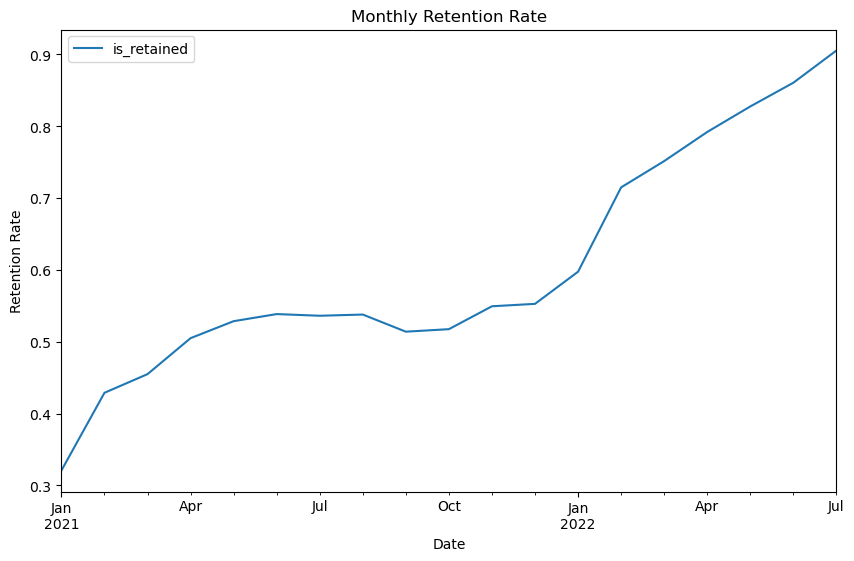

In [6]:
# Time Series Analysis 
data["observation_dt"] = pd.to_datetime(data["observation_dt"])
data.set_index("observation_dt", inplace=True)
data.resample("M").mean().plot(y="is_retained", figsize=(10, 6))
plt.title("Monthly Retention Rate")
plt.xlabel("Date")
plt.ylabel("Retention Rate")
plt.show()

# Training Data preprocessing and Feature Engineering Pipeline

In [7]:
# Load the training dataset
data = pd.read_csv("/kaggle/input/aicomm/train.csv")

# Remove Unnecessary Columns
columns_to_drop = ["ID", "subscription_id"]
data = data.drop(columns=columns_to_drop)

# Handle Missing Data
data = data.dropna()

# Convert Data Types
data["observation_dt"] = pd.to_datetime(data["observation_dt"])
data["learner_gender"] = data["learner_gender"].astype("category")

# Feature Engineering
data["days_since_registration"] = (pd.Timestamp.now() - data["observation_dt"]).dt.days

# Encoding Categorical Variables (One-Hot Encoding)
data = pd.get_dummies(data, columns=["specialization_domain", "learner_country_group", "specialization_id", "learner_gender", "subscription_period_order"])

# Handling Boolean Columns
boolean_columns = ["is_professional_certificate", "is_gateway_certificate", "is_subscription_started_with_free_trial", "is_active_capstone_during_pay_period"]
data[boolean_columns] = data[boolean_columns].astype(bool)

# Data Preparation and Model Training Pipeline using CatBoostClassifier

In [8]:
# Splitting the data into features (X) and target (y)
y = data['is_retained']
X = data.drop('is_retained', axis=1)

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Training: CatBoostClassifier with Custom Parameters
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 8,
    'l2_leaf_reg': 5,
    'verbose': 100,
    'random_state': 42
}
model = CatBoostClassifier(**catboost_params)
model.fit(X_train, y_train)

0:	learn: 0.6851573	total: 158ms	remaining: 2m 38s
100:	learn: 0.5838449	total: 8.19s	remaining: 1m 12s
200:	learn: 0.5753001	total: 15.8s	remaining: 1m 2s
300:	learn: 0.5697829	total: 23.8s	remaining: 55.3s
400:	learn: 0.5652216	total: 31.4s	remaining: 46.9s
500:	learn: 0.5618118	total: 38.7s	remaining: 38.5s
600:	learn: 0.5586600	total: 46s	remaining: 30.5s
700:	learn: 0.5556990	total: 53.9s	remaining: 23s
800:	learn: 0.5530645	total: 1m 1s	remaining: 15.3s
900:	learn: 0.5504136	total: 1m 8s	remaining: 7.56s
999:	learn: 0.5479932	total: 1m 16s	remaining: 0us


# Cross-Validation and Performance Evaluation using ROC AUC Scores

In [9]:
# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation ROC AUC Scores:", cv_scores)
print("Mean CV ROC AUC:", np.mean(cv_scores))
print("Standard Deviation of CV ROC AUC:", np.std(cv_scores))

0:	learn: 0.6851452	total: 89.6ms	remaining: 1m 29s
100:	learn: 0.5834295	total: 7.12s	remaining: 1m 3s
200:	learn: 0.5742349	total: 13.8s	remaining: 55s
300:	learn: 0.5683328	total: 20.3s	remaining: 47.2s
400:	learn: 0.5631617	total: 26.8s	remaining: 40s
500:	learn: 0.5592281	total: 33.7s	remaining: 33.6s
600:	learn: 0.5557725	total: 40.2s	remaining: 26.7s
700:	learn: 0.5524084	total: 46.5s	remaining: 19.8s
800:	learn: 0.5494412	total: 52.8s	remaining: 13.1s
900:	learn: 0.5463947	total: 59.2s	remaining: 6.5s
999:	learn: 0.5435888	total: 1m 6s	remaining: 0us
0:	learn: 0.6851937	total: 82.2ms	remaining: 1m 22s
100:	learn: 0.5828746	total: 7.52s	remaining: 1m 6s
200:	learn: 0.5739437	total: 16.2s	remaining: 1m 4s
300:	learn: 0.5679499	total: 25.4s	remaining: 59s
400:	learn: 0.5628271	total: 32.1s	remaining: 47.9s
500:	learn: 0.5588745	total: 38.7s	remaining: 38.5s
600:	learn: 0.5550001	total: 45.9s	remaining: 30.5s
700:	learn: 0.5517461	total: 52.6s	remaining: 22.4s
800:	learn: 0.5488365

# Model Evaluation on Validation Set: Accuracy and Classification Report

In [10]:
# Model Evaluation on Validation Set
y_pred_probs = model.predict_proba(X_val)[:, 1]

y_pred = (y_pred_probs > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.6935213564235351
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65     30232
           1       0.70      0.76      0.73     36001

    accuracy                           0.69     66233
   macro avg       0.69      0.69      0.69     66233
weighted avg       0.69      0.69      0.69     66233



# Test Data Preprocessing and Feature Engineering Pipeline

In [11]:
# Load the test dataset
test_data = pd.read_csv('/kaggle/input/aicomm/test.csv')

# Remove Unnecessary Columns
test_data = test_data.drop(columns= "subscription_id")
test_data = test_data.drop(columns="Unnamed: 0")

# Handle Missing Data
test_data.fillna(0, inplace=True)

# Convert Data Types
test_data["observation_dt"] = pd.to_datetime(test_data["observation_dt"])
test_data["learner_gender"] = test_data["learner_gender"].astype("category")

# Feature Engineering
test_data["days_since_registration"] = (pd.Timestamp.now() - test_data["observation_dt"]).dt.days

# Encoding Categorical Variables (One-Hot Encoding)
test_data = pd.get_dummies(test_data, columns=["specialization_domain", "learner_country_group", "specialization_id", "learner_gender", "subscription_period_order"])

# Ensure categorical columns have the same names as in the training data
for col in data.columns:
    if col not in test_data.columns:
        test_data[col] = 0

# Handling Boolean Columns
test_data[boolean_columns] = test_data[boolean_columns].astype(bool)

# Generating Predictions for Test Data and Creating Submission CSV

In [12]:
test_pred_probs = model.predict_proba(test_data)[:, 1]

# Create a submission DataFrame with new index column and TARGET column
submission = pd.DataFrame({
    'TARGET': test_pred_probs
})

# Create a new index column
submission['ID'] = submission.index

# Reorder columns to have the index column first
submission = submission[['ID', 'TARGET']]

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

# Visualizing High Importance Features in the Model

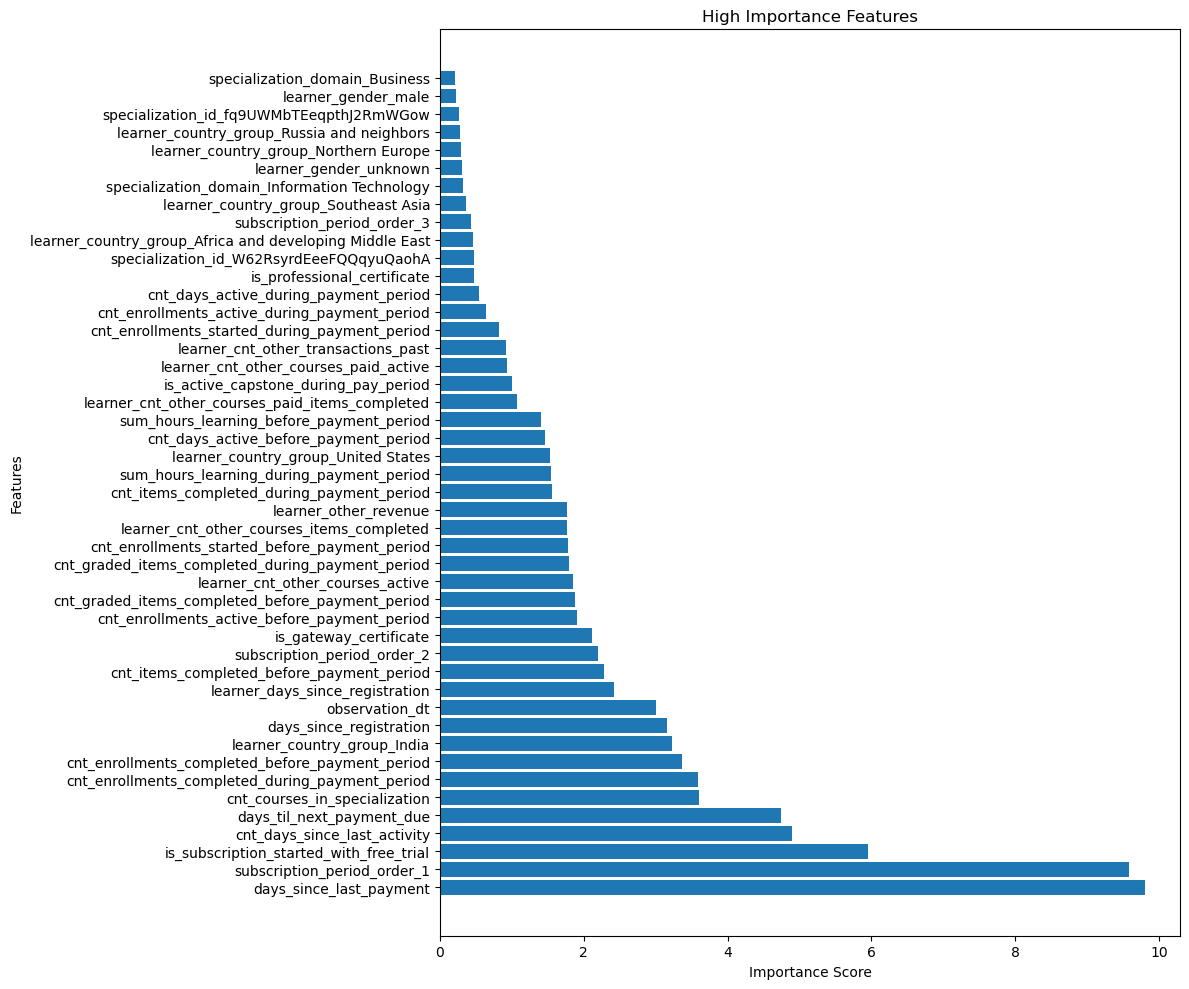

In [13]:
import matplotlib.pyplot as plt

# Get feature importance scores from the model
feature_importance = model.get_feature_importance(type='FeatureImportance')

# Create a dictionary to associate feature names with importance scores
feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importance)}

# Define a threshold for high importance
high_importance_threshold = 0.2

# Filter features with importance above the threshold
high_importance_features = [(feature, importance) for feature, importance in feature_importance_dict.items() if importance > high_importance_threshold]

# Sort the high importance features by importance in descending order
sorted_high_importance_features = sorted(high_importance_features, key=lambda x: x[1], reverse=True)

# Extract feature names and importance scores for plotting
feature_names = [feature for feature, _ in sorted_high_importance_features]
importance_scores = [importance for _, importance in sorted_high_importance_features]

# Create a bar plot to visualize high importance features
plt.figure(figsize=(12, 10))
plt.barh(feature_names, importance_scores)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('High Importance Features')
plt.tight_layout()
plt.show()

# Visualizing Confusion Matrix Heatmap for Model Evaluation

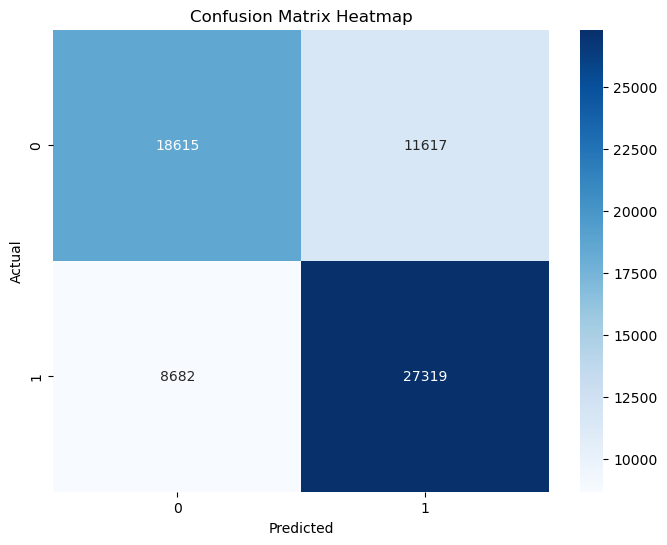

In [14]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting Learning Curve

0:	learn: 0.6855755	total: 28.3ms	remaining: 28.3s
100:	learn: 0.5652709	total: 2.35s	remaining: 20.9s
200:	learn: 0.5401498	total: 4.6s	remaining: 18.3s
300:	learn: 0.5197153	total: 6.72s	remaining: 15.6s
400:	learn: 0.5012031	total: 8.85s	remaining: 13.2s
500:	learn: 0.4846220	total: 10.9s	remaining: 10.9s
600:	learn: 0.4712972	total: 13.2s	remaining: 8.76s
700:	learn: 0.4583183	total: 15.3s	remaining: 6.53s
800:	learn: 0.4465098	total: 17.4s	remaining: 4.32s
900:	learn: 0.4353884	total: 19.5s	remaining: 2.15s
999:	learn: 0.4249434	total: 21.6s	remaining: 0us
0:	learn: 0.6852528	total: 42.9ms	remaining: 42.8s
100:	learn: 0.5790598	total: 3.62s	remaining: 32.2s
200:	learn: 0.5661788	total: 7.14s	remaining: 28.4s
300:	learn: 0.5550896	total: 10.6s	remaining: 24.5s
400:	learn: 0.5458742	total: 13.9s	remaining: 20.7s
500:	learn: 0.5380128	total: 17.1s	remaining: 17s
600:	learn: 0.5315280	total: 20.6s	remaining: 13.7s
700:	learn: 0.5247936	total: 24.2s	remaining: 10.3s
800:	learn: 0.51808

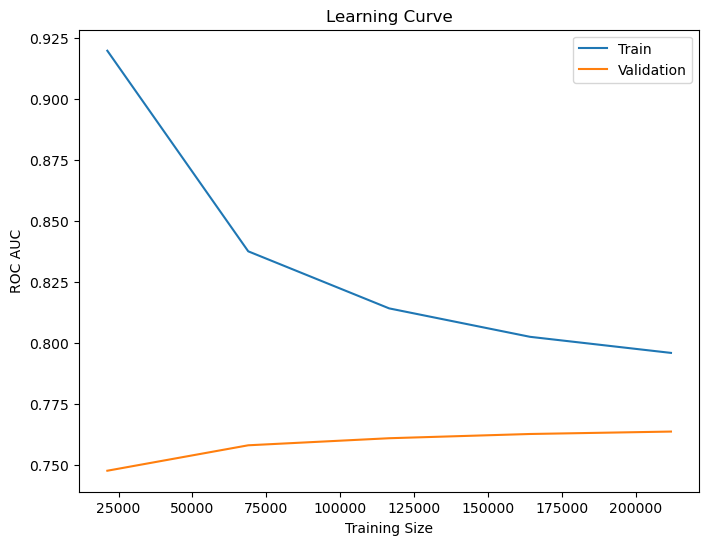

In [15]:
# Calculate learning curve data
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='roc_auc')

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Plotting ROC Curve for Model Evaluation

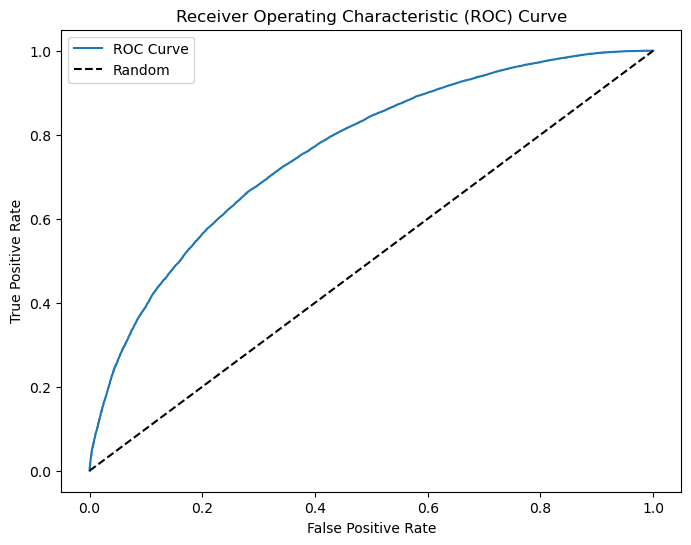

In [16]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Measuring Model Inference Time

In [33]:
# Measure inference time
start_time = time.time()
y_pred_probs = model.predict_proba(X_val)[:, 1]
end_time = time.time()

inference_time = end_time - start_time
print(f'Inference time for {len(X_val)} samples: {inference_time:.10f} seconds')

Inference time for 66233 samples: 0.5798683167 seconds


# Measuring Model Inference Time on Test Data

In [34]:
# Measure inference time on test data
start_time = time.time()
test_pred_probs = model.predict_proba(test_data)[:, 1]
end_time = time.time()

inference_time = end_time - start_time
print(f'Inference time for {len(test_data)} samples: {inference_time:.10f} seconds')

Inference time for 82791 samples: 0.7368419170 seconds
